Dataset shape: (9182, 10)

First 5 rows:
   Daily Time Spent on Site   Age  Area Income  Daily Internet Usage  \
0                     78.84  30.0     68448.94                161.79   
1                     60.23  35.0     66815.54                216.24   
2                     46.20  49.0     62109.80                135.24   
3                     87.85  31.0     50055.33                134.46   
4                     64.38  37.0     55121.65                232.54   

                           Ad Topic Line               City  Gender  \
0         Front-line even-keeled website           Silvaton    Male   
1  Front-line fresh-thinking open system    West Jeremyside    Male   
2              Enhanced maximized access       Lake Vanessa    Male   
3     Total zero administration software    Port Sherrystad    Male   
4            Devolved regional moderator  South Patrickfort  Female   

                  Country            Timestamp  Clicked on Ad  
0                    Peru  2016-04-

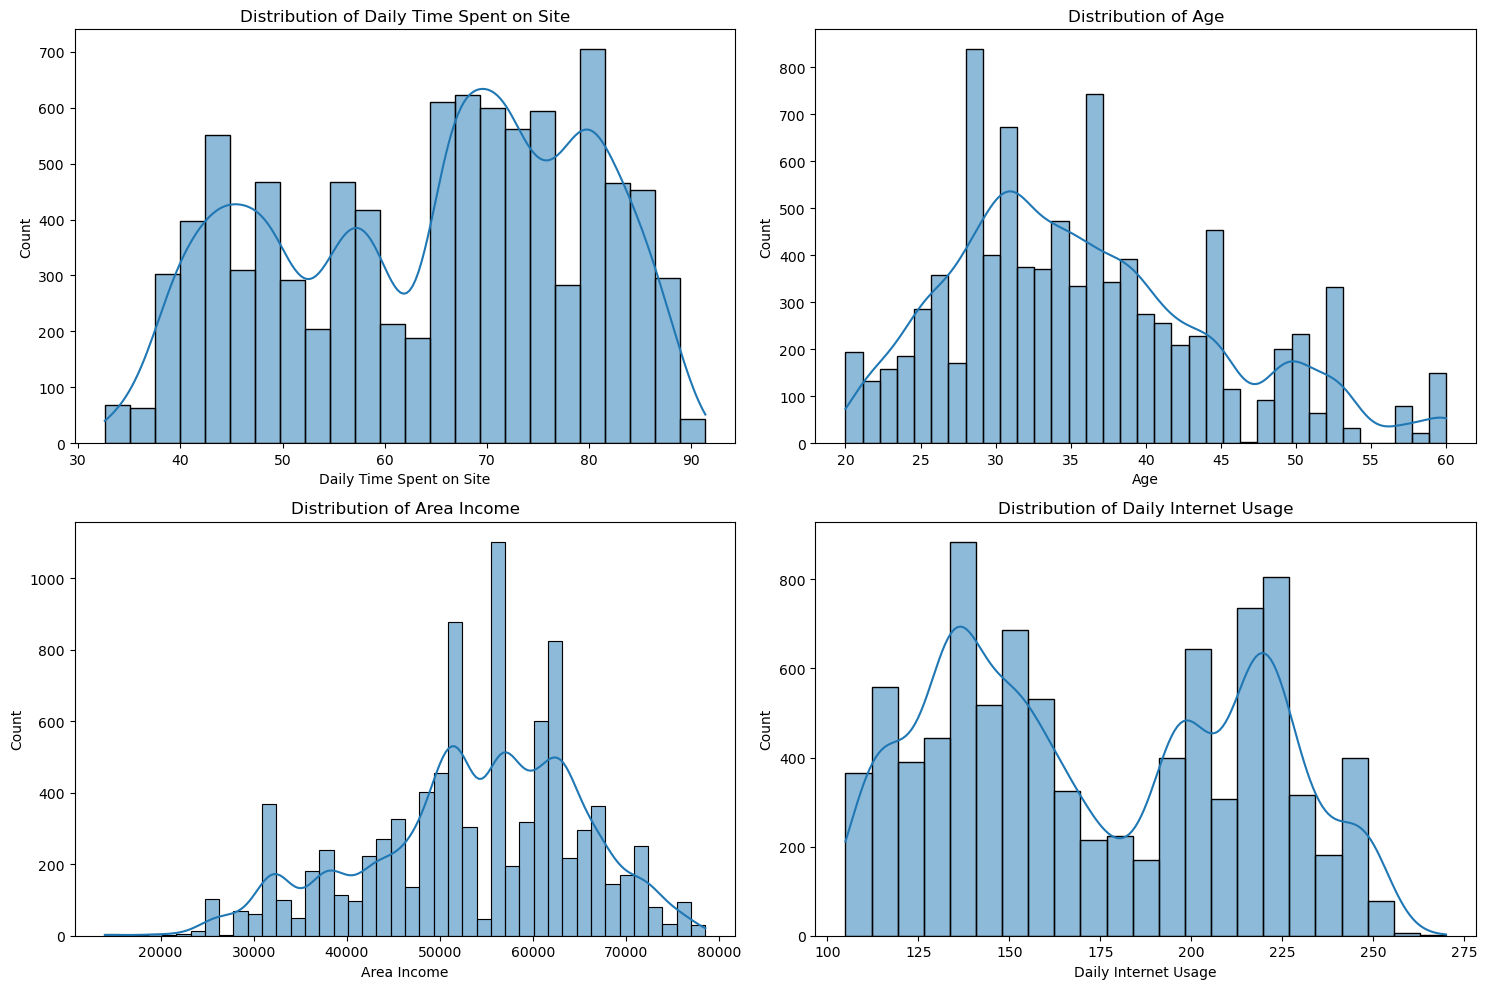

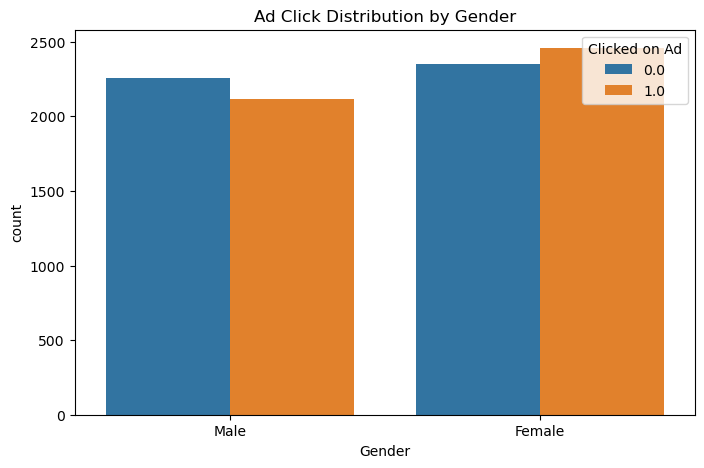

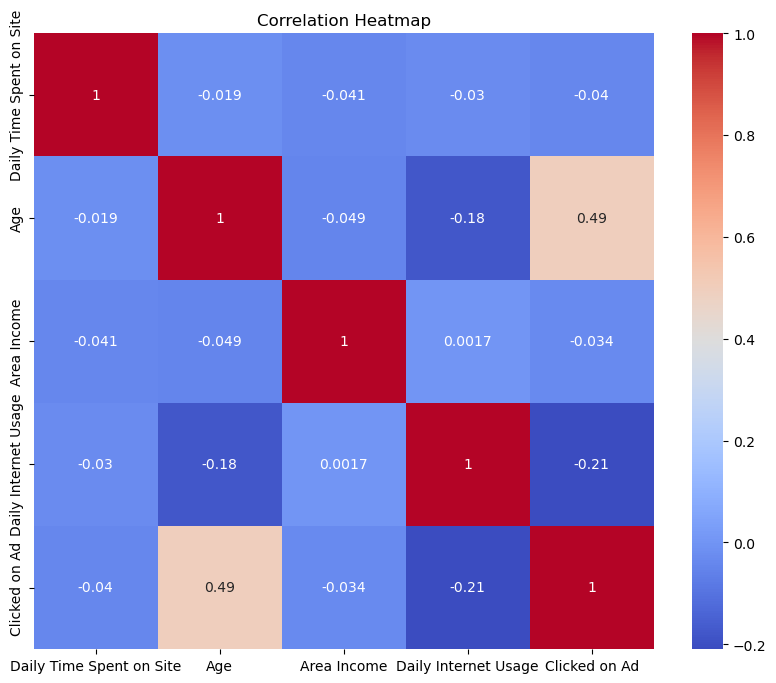

Model Evaluation:
Accuracy: 0.8613

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      1362
         1.0       0.87      0.85      0.86      1393

    accuracy                           0.86      2755
   macro avg       0.86      0.86      0.86      2755
weighted avg       0.86      0.86      0.86      2755


Confusion Matrix:
[[1187  175]
 [ 207 1186]]


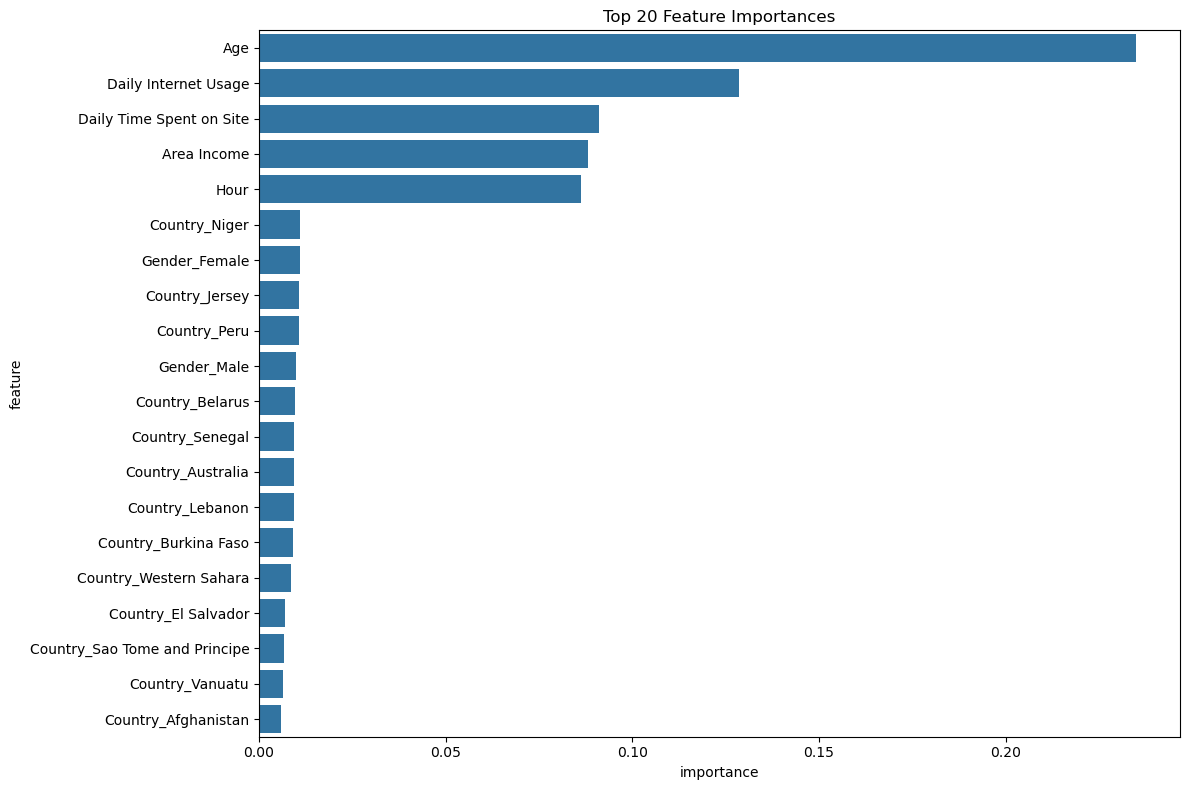

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best score: 0.8520301843861763


['ad_click_model.pkl']

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('cleaned_ad.csv')

# Exploratory Data Analysis
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nSummary statistics:")
print(df.describe())

# Visualizations
plt.figure(figsize=(15, 10))

# Distribution of numerical features
numerical_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Click distribution by gender
plt.figure(figsize=(8, 5))
sns.countplot(x='Gender', hue='Clicked on Ad', data=df)
plt.title('Ad Click Distribution by Gender')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols + ['Clicked on Ad']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Feature Engineering
# Extract hour from timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour

# Drop columns that might not be useful
df.drop(['Ad Topic Line', 'City', 'Timestamp'], axis=1, inplace=True)

# Prepare data for modeling
X = df.drop('Clicked on Ad', axis=1)
y = df['Clicked on Ad']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define preprocessing steps
numerical_features = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Hour']
categorical_features = ['Country', 'Gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create pipeline with Random Forest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature Importance (after preprocessing)
# Get feature names after one-hot encoding
cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(cat_feature_names)

# Get feature importances
importances = pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# Hyperparameter tuning (optional)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Save the best model
joblib.dump(grid_search.best_estimator_, 'ad_click_model.pkl')